!*********************************************************************!

!

!   This program calculates the unpolarized absorption spectrum and 

!   band dispersion of a linear, 1D aggregate using the Frenkel/

!   charge-transfer Holstein model. See the README file for more 

!   information.

!                                                   Written By:

!                                                   Nicholas Hestand

!*********************************************************************!

In [3]:
import sys
import re
from os import path
import numpy as np
import scipy.linalg.lapack as lapack
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Common Variable

In [2]:
'''!*********************************************************************!
!    Module containing variables and parameters used in exciton1D     !
!    subroutines.
!*********************************************************************!'''
class load_commonvar():
    #module commonvar
    '''!=================================================================!
    !   Simulation parameters, all in units of hw                     !
    !=================================================================!'''
            #Simulation Title  
    task_title='task_title'

    nmol = int(1)

            #!Vibrational Parameters
    vibmax    = int(0)      #!Max vibrations in basis set
    hw        = 1400.0      #!vibration energy
    lambda_n  = 1.0         #!Neutral lambda (harmonic shift)
    lambda_c  = 0.0         #!Cation lambda (harmonic shift)
    lambda_a  = 0.0         #!Anion lambda (harmonic shift)

            #!Coupling and Energies
    JCoul     = 0.0        #!Nearest neighbor Coulomb coupling
    ES1       = 0.0        #!Monomer Transition Energy
    te        = 0.0        #!Nearest neighbor electron transfer integral
    th        = 0.0        #!Nearest neighbor hole transfer integral
    ECT       = 0.0        #!Charge Transfer Energy
    ECTInf    = 0.0        #!Charge Transfer Energy and Infinite Separation

            #!multiparticle basis states
    one_state    =True
    two_state    =False
    ct_state     =False

            #!absorption linewidth
    abs_lw   = 0.10

            #!franck condon tables
    fc_gf=np.empty([1,1])
    fc_gc=np.empty([1,1])
    fc_ga=np.empty([1,1])
    fc_af=np.empty([1,1])
    fc_cf=np.empty([1,1])

    fc_gf[:]=np.nan
    fc_gc[:]=np.nan
    fc_ga[:]=np.nan
    fc_af[:]=np.nan
    fc_cf[:]=np.nan

            #!constants
    pi = 4.0*np.arctan(1.0)
            #!cm-1 per electronvolt
    ev = 8065.0
            #!plancks constant times the speed of light in nm*hw 
    hc = 1.23984193e3 * ev 
            #!boltzman constant units of cm-1 k
    kbman = 0.6956925 
            #!reduced planks constant in wavenumber * s
    hbar = 6.58211951440e-16 * ev 

            #!basis set counter
    kount = int(0)

            #!basis set indexes
    nx_1p=np.empty([1])
    nx_1p[:]=np.nan
    nx_2p=np.empty([1,1,1])
    nx_2p[:]=np.nan
    nx_ct=np.empty([1,1,1])
    nx_ct[:]=np.nan

            #!the hamiltonian and eigenvalues
    h=np.empty([1,1],dtype='complex')
    eval=np.empty([1])
    h[:]=np.nan
    eval[:]=np.nan

            #!empty parameter
    empty = -1  
            #!parameters for complex numbers
    complex_zero = complex( 0.0, 0.0 )
    img = complex( 0.0, 1.0 )

            #!bounds integer 
    nlbnd=None
    nubnd=None

            #!number of eigenstates to find for each k
    esnum = 1    

# read in parameters


In [3]:
import read_in_para

# number of particles


In [4]:
import num_par

# Frank Condon Table

In [5]:
import FC_Table

# Build Hamiltonian

In [6]:
import Hamiltonian

# Diagonalization

In [7]:
import Diag

# Absorption

In [8]:
import ABS

# Dispersion

In [9]:
import Disp

In [10]:
#def exciton_main():
#read the user input file and set simulation parameters
parameters=load_commonvar()
parameters=read_in_para.read_in_para(parameters)
#index the multiparticle basis set
parameters.kount = 0
if (parameters.one_state):
    parameters=num_par.index_1p(parameters)
if (parameters.two_state):
    parameters=num_par.index_2p(parameters)
if (parameters.ct_state):
    parameters=num_par.index_ct(parameters)
#make sure the number of requested eigenstates is less than the
#total number of eigenstates possible
parameters.esnum = min(parameters.esnum,parameters.kount)

#build the franck-condon table for the vibrational overlap factors
parameters=FC_Table.set_fctable(parameters)  

#allocate space for the Hamiltonian matrix and eigenvalue array
parameters.h=np.zeros([parameters.kount+1,parameters.kount+1],dtype=complex) # !the Hamiltonian!!!!!!!!!!!!!!!!!!!!!!!!!!
parameters.eval=np.zeros([parameters.kount])    # !eigenvalues

print(' Will now build the Hamiltonian, the diminsion of each k-block is:',parameters.kount)
print('********************************************************************')

#build each k-block of the Hamiltonian diagonalize, and calculate the observables
for k in range(parameters.nlbnd,parameters.nubnd+1):
    #!initialize hamiltonian to zero
    parameters.h[:]=complex(0,0)
    #build the hamiltonian
    if ( parameters.one_state ):
        parameters=Hamiltonian.build_h1p(k,parameters)
    if ( parameters.two_state ):
        parameters=Hamiltonian.build_h2p(k,parameters)
    if ( parameters.one_state) and (parameters.two_state ):
        parameters=Hamiltonian.build_h1p2p(k,parameters)
    if ( parameters.ct_state ):
        parameters=Hamiltonian.build_hct(k,parameters)
    if ( parameters.one_state) and (parameters.ct_state ):
        parameters=Hamiltonian.build_h1pct(k,parameters)
    if (parameters.two_state) and (parameters.ct_state ):
        parameters=Hamiltonian.build_h2pct(k,parameters)
    #diagonalize the hamiltonian
    if ( k == 0) or (parameters.esnum == parameters.kount ):
        print(parameters.h.shape)
        parameters.h,parameters.eval=Diag.diagonalize(parameters.h, parameters.kount, parameters.eval, 'A', parameters.kount)
    else:
        parameters.h,parameters.eval=Diag.diagonalize(parameters.h, parameters.kount, parameters.eval, 'I', parameters.esnum)
    #calculate
    # absorption spectrum
    #(only k=0 absorbes assuming parallel dipoles)
    if ( k == 0 ):
        absorption(parameters)
    dispersion(k,parameters)
    
    print('Done with wavevector k: ', k)

Reading the input file...
**********************************
**********************************
Calculating derived parameters in units of hw.
**********************************
**********************************
 Will now build the Hamiltonian, the diminsion of each k-block is: 230
********************************************************************
build h1p
build h2p
Build h1p2p
Start with hct
start with h1pct
build h2pct


In [ ]:
parameters.h

# Parameter Out

In [ ]:
'''!*********************************************************************!
!        Write the simulation parameters to a file so that the        !
!   simulation can be reproduced at a later time.                     !
!*********************************************************************!'''
def para_out(p):
    #integer f_no
    #character*100 f_name
    f_name =task_title+'_para.csv'
    with open(f_name) as para_wf:
        write('parameter, values, all energies in cm-1')
        write('task title, ',           trim(p.task_title))
        write('nmol, ',                 p.nmol)
        write('vibmax, ',               p.vibmax)
        write('@@@@@@,@@@@@@')
        write('basis state, on')
        write('1p, ',                   p.one_state)
        write('2p, ',                   p.two_state)
        write('ct, ',                   p.ct_state)
        write('total,',                 p.kount)
        write('@@@@@@,@@@@@@')
        write('vib energy,',            p.hw)
        write('lambda,',                p.lambda_n)
        write('lambda+,',               p.lambda_c)
        write('lambda-',                p.lambda_a)
        write('JCoul,',                 p.JCoul*p.hw)
        write('ES1,',                   p.ES1*p.hw)
        write('te,',                    p.te*p.hw)
        write('th,',                    p.th*p.hw)
        write('ECT,',                   p.ECT*p.hw)
        write('@@@@@@@@,@@@@@@@@')
        write('abs linewidth,',         p.abs_lw*p.hw)

# Main Exciton

In [ ]:
para_out()
print('********************************************************************')
print('Program exited successfully.')

In [ ]:
#program exciton_main
    #integer k   !the k-index
    
    #!read the user input file and set simulation parameters 
   
    #index the multiparticle basis set
    
    #make sure the number of requested eigenstates is less than the
    #total number of eigenstates possible

    #build the franck-condon table for the vibrational overlap factors
    
    #allocate space for the Hamiltonian matrix and eigenvalue array
    #allocate ( h(kount,kount) ) !the Hamiltonian
    #allocate ( eval(kount) )    !eigenvalues
    
    #build each k-block of the Hamiltonian diagonalize, and calculate the observables

    #write the parameter file
    


In [ ]:
parameters.nx_2p.shape

In [ ]:
nx_1p='     1           2           3           4           5'


nx_2p='6          82         139         177          -1          10          85         141         178          -1          14          88         143         179          -1          18          91         145         180          -1          22          94         147         181          -1          26          97         149         182          -1          30         100         151         183          -1          34         103         153         184          -1          38         106         155         185          -1          -1          -1          -1          -1          -1          42         109         157         186          -1          46         112         159         187          -1          50         115         161         188          -1          54         118         163         189          -1          58         121         165         190          -1          62         124         167         191          -1          66         127         169         192          -1          70         130         171         193          -1          74         133         173         194          -1          78         136         175         195          -1           7          83         140          -1          -1          11          86         142          -1          -1          15          89         144          -1          -1          19          92         146          -1          -1          23          95         148          -1          -1          27          98         150          -1          -1          31         101         152          -1          -1          35         104         154          -1          -1          39         107         156          -1          -1          -1          -1          -1          -1          -1          43         110         158          -1          -1          47         113         160          -1          -1          51         116         162          -1          -1          55         119         164          -1          -1          59         122         166          -1          -1          63         125         168          -1          -1          67         128         170          -1          -1          71         131         172          -1          -1          75         134         174          -1          -1          79         137         176          -1          -1           8          84          -1          -1          -1          12          87          -1          -1          -1          16          90          -1          -1          -1          20          93          -1          -1          -1          24          96          -1          -1          -1          28          99          -1          -1          -1          32         102          -1          -1          -1          36         105          -1          -1          -1          40         108          -1          -1          -1          -1          -1          -1          -1          -1          44         111          -1          -1          -1          48         114          -1          -1          -1          52         117          -1          -1          -1          56         120          -1          -1          -1          60         123          -1          -1          -1          64         126          -1          -1          -1          68         129          -1          -1          -1          72         132          -1          -1          -1          76         135          -1          -1          -1          80         138          -1          -1          -1           9          -1          -1          -1          -1          13          -1          -1          -1          -1          17          -1          -1          -1          -1          21          -1          -1          -1          -1          25          -1          -1          -1          -1          29          -1          -1          -1          -1          33          -1          -1          -1          -1          37          -1          -1          -1          -1          41          -1          -1          -1          -1          -1          -1          -1          -1          -1          45          -1          -1          -1          -1          49          -1          -1          -1          -1          53          -1          -1          -1          -1          57          -1          -1          -1          -1          61          -1          -1          -1          -1          65          -1          -1          -1          -1          69          -1          -1          -1          -1          73          -1          -1          -1          -1          77          -1          -1          -1          -1          81          -1          -1          -1          -1'



nx_ct='         196         291         367         424         462         201         295         370         426         463         206         299         373         428         464         211         303         376         430         465         216         307         379         432         466         221         311         382         434         467         226         315         385         436         468         231         319         388         438         469         236         323         391         440         470          -1          -1          -1          -1          -1         241         327         394         442         471         246         331         397         444         472         251         335         400         446         473         256         339         403         448         474         261         343         406         450         475         266         347         409         452         476         271         351         412         454         477         276         355         415         456         478         281         359         418         458         479         286         363         421         460         480         197         292         368         425          -1         202         296         371         427          -1         207         300         374         429          -1         212         304         377         431          -1         217         308         380         433          -1         222         312         383         435          -1         227         316         386         437          -1         232         320         389         439          -1         237         324         392         441          -1          -1          -1          -1          -1          -1         242         328         395         443          -1         247         332         398         445          -1         252         336         401         447          -1         257         340         404         449          -1         262         344         407         451          -1         267         348         410         453          -1         272         352         413         455          -1         277         356         416         457          -1         282         360         419         459          -1         287         364         422         461          -1         198         293         369          -1          -1         203         297         372          -1          -1         208         301         375          -1          -1         213         305         378          -1          -1         218         309         381          -1          -1         223         313         384          -1          -1         228         317         387          -1          -1         233         321         390          -1          -1         238         325         393          -1          -1          -1          -1          -1          -1          -1         243         329         396          -1          -1         248         333         399          -1          -1         253         337         402          -1          -1         258         341         405          -1          -1         263         345         408          -1          -1         268         349         411          -1          -1         273         353         414          -1          -1         278         357         417          -1          -1         283         361         420          -1          -1         288         365         423          -1          -1         199         294          -1          -1          -1         204         298          -1          -1          -1         209         302          -1          -1          -1         214         306          -1          -1          -1         219         310          -1          -1          -1         224         314          -1          -1          -1         229         318          -1          -1          -1         234         322          -1          -1          -1         239         326          -1          -1          -1          -1          -1          -1          -1          -1         244         330          -1          -1          -1         249         334          -1          -1          -1         254         338          -1          -1          -1         259         342          -1          -1          -1         264         346          -1          -1          -1         269         350          -1          -1          -1         274         354          -1          -1          -1         279         358          -1          -1          -1         284         362          -1          -1          -1         289         366          -1          -1          -1         200          -1          -1          -1          -1         205          -1          -1          -1          -1         210          -1          -1          -1          -1         215          -1          -1          -1          -1         220          -1          -1          -1          -1         225          -1          -1          -1          -1         230          -1          -1          -1          -1         235          -1          -1          -1          -1         240          -1          -1          -1          -1          -1          -1          -1          -1          -1         245          -1          -1          -1          -1         250          -1          -1          -1          -1         255          -1          -1          -1          -1         260          -1          -1          -1          -1         265          -1          -1          -1          -1         270          -1          -1          -1          -1         275          -1          -1          -1          -1         280          -1          -1          -1          -1         285          -1          -1          -1          -1         290          -1          -1          -1          -1'

In [ ]:
print(np.asarray(nx_1p.split(),'int'))
print(np.reshape(np.asarray(nx_2p.split(),'int'),(5,20,4))[0])
print(np.reshape(np.asarray(nx_ct.split(),'int'),(5,20,5))[0])

In [ ]:
  gf='0.60653065971263342       0.60653065971263342       0.42888194248035344       0.24761510494160160       0.12380755247080080      -0.60653065971263342        0.0000000000000000       0.42888194248035344       0.49523020988320327       0.37142265741240243       0.42888194248035344      -0.42888194248035344      -0.30326532985631671       0.17509031982842507       0.43772579957106278      -0.24761510494160160       0.49523020988320327      -0.17509031982842507      -0.40435377314175563       -5.0544221642719475E-002  0.12380755247080080      -0.37142265741240243       0.43772579957106278        5.0544221642719475E-002 -0.37908166232039564'

  ga='  0.88249690258459546       0.44124845129229773       0.15600488604842289        4.5034731477476914E-002   1.1258682869369228E-002 -0.44124845129229773       0.66187267693844665       0.54601710116948010       0.24769102312612301        8.4440121520269223E-002  0.15600488604842289      -0.54601710116948010       0.46882647949806633       0.58115964330366532       0.32043391291743195       -4.5034731477476914E-002  0.24769102312612301      -0.58115964330366532       0.30106014124630726       0.57856405006685385        1.1258682869369228E-002  -8.4440121520269223E-002  0.32043391291743195      -0.57856405006685385       0.15641912872959382'
gc='  0.88249690258459546       0.44124845129229773       0.15600488604842289        4.5034731477476914E-002   1.1258682869369228E-002 -0.44124845129229773       0.66187267693844665       0.54601710116948010       0.24769102312612301        8.4440121520269223E-002  0.15600488604842289      -0.54601710116948010       0.46882647949806633       0.58115964330366532       0.32043391291743195       -4.5034731477476914E-002  0.24769102312612301      -0.58115964330366532       0.30106014124630726       0.57856405006685385        1.1258682869369228E-002  -8.4440121520269223E-002  0.32043391291743195      -0.57856405006685385       0.15641912872959382'
cf='0.88249690258459546 0.44124845129229773 0.15600488604842289 4.5034731477476914E-002 1.1258682869369228E-002 -0.44124845129229773 0.66187267693844665 0.54601710116948010 0.24769102312612301 8.4440121520269223E-002 0.15600488604842289 -0.54601710116948010 0.46882647949806633 0.58115964330366532 0.32043391291743195 -4.5034731477476914E-002 0.24769102312612301 -0.58115964330366532 0.30106014124630726 0.57856405006685385 1.1258682869369228E-002 -8.4440121520269223E-002 0.32043391291743195 -0.57856405006685385 0.15641912872959382'
af='  0.88249690258459546       0.44124845129229773       0.15600488604842289        4.5034731477476914E-002   1.1258682869369228E-002 -0.44124845129229773       0.66187267693844665       0.54601710116948010       0.24769102312612301        8.4440121520269223E-002  0.15600488604842289      -0.54601710116948010       0.46882647949806633       0.58115964330366532       0.32043391291743195       -4.5034731477476914E-002  0.24769102312612301      -0.58115964330366532       0.30106014124630726       0.57856405006685385        1.1258682869369228E-002  -8.4440121520269223E-002  0.32043391291743195      -0.57856405006685385       0.15641912872959382'

In [ ]:
print(np.reshape(np.asarray(gf.split(),'float'),(5,5))-parameters.fc_cf.transpose())
print('\n')

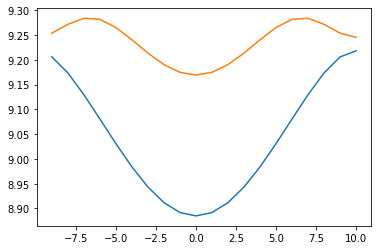

In [22]:
gccdisp=pd.read_csv('/Users/livi/Git/exciton1d-1/example_disp.csv')
pydisp=pd.read_csv('/Users/livi/Git/exciton1d-1/exampleplus_disp.csv')
plt.plot(gccdisp[' k'],gccdisp['energy'])
plt.plot(pydisp['k'],pydisp['energy'])
plt.show()